In [2]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [28]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

df.head()

,id,아파트명,계약년월,계약일,층,구,동,건축년도,closest_bus_stop_distance,closest_subway_station_distance,...,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target,apt_mean_target,mean_target,전용면적,계약년
0,0,개포6차우성,2017-12-01,8,3,강남구,개포동,1987,95.560091,1187.188361,...,0,57,0,6.609733,0,124000.0,104403.465347,119240.517241,79.97,2017
1,1,개포6차우성,2017-12-01,22,4,강남구,개포동,1987,95.560091,1187.188361,...,0,57,0,6.609733,0,123500.0,104403.465347,119240.517241,79.97,2017
2,2,개포6차우성,2017-12-01,28,5,강남구,개포동,1987,95.560091,1187.188361,...,0,57,0,6.609733,0,91500.0,104403.465347,86362.500000,54.98,2017
3,3,개포6차우성,2018-01-01,3,4,강남구,개포동,1987,95.560091,1187.188361,...,0,57,0,6.609733,0,130000.0,104403.465347,119240.517241,79.97,2018
4,4,개포6차우성,2018-01-01,8,2,강남구,개포동,1987,95.560091,1187.188361,...,0,57,0,6.609733,0,117000.0,104403.465347,119240.517241,79.97,2018


In [29]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# 올해 + 1년 전 우리 구 평균 부동산 가격 피쳐 만들기

In [30]:
from IPython.display import display

for region in regions:
    chunk = chunks[region]

    year_target_means = {}

    for year in range(2007, 2024):
        this_year_target_mean = chunk.loc[(chunk['계약년'] == year) & (chunk['is_test'] == 0) ,'target'].mean()
        chunk.loc[(chunk['계약년'] == year) , '올해 지역 평균'] =  this_year_target_mean
        year_target_means[year] = this_year_target_mean

        if year == 2007:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = this_year_target_mean
        else:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = year_target_means[year-1]
    
    chunks[region] = chunk

In [33]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id','층', '건축년도',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', 'is_test', 'target', '전용면적', '계약년',
        '올해 지역 평균', '작년 지역 평균', 'apt_mean_target', 'mean_target']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[388]	training's rmse: 12549.8	valid_1's rmse: 43853.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[605]	training's rmse: 12640.1	valid_1's rmse: 14589.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[757]	training's rmse: 11514.1	valid_1's rmse: 48808
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[893]	training's rmse: 14277.4	valid_1's rmse: 41047.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1889]	training's rmse: 13712.2	valid_1's rmse: 23025.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1919]	training's rmse: 15022.4	valid_1's rmse: 24816.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2118

  4%|▍         | 1/25 [02:22<57:00, 142.51s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[253]	training's rmse: 5595.21	valid_1's rmse: 15394.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[576]	training's rmse: 4544.81	valid_1's rmse: 6943.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[737]	training's rmse: 4288.25	valid_1's rmse: 14552.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1077]	training's rmse: 4572.45	valid_1's rmse: 28056
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1183]	training's rmse: 7360.37	valid_1's rmse: 11022.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1221]	training's rmse: 7290.59	valid_1's rmse: 7925.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123

  8%|▊         | 2/25 [04:15<48:00, 125.25s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[474]	training's rmse: 3130.24	valid_1's rmse: 6449.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[927]	training's rmse: 2754.18	valid_1's rmse: 2963.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[958]	training's rmse: 2695.76	valid_1's rmse: 24958.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1168]	training's rmse: 3560.03	valid_1's rmse: 8101.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1190]	training's rmse: 4465.32	valid_1's rmse: 10641.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1404]	training's rmse: 4178.5	valid_1's rmse: 7222.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17

 12%|█▏        | 3/25 [05:21<35:57, 98.08s/it] 

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[542]	training's rmse: 3845.54	valid_1's rmse: 10340
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[761]	training's rmse: 3802.23	valid_1's rmse: 5658.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[762]	training's rmse: 4490.44	valid_1's rmse: 26107.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[985]	training's rmse: 4942.83	valid_1's rmse: 8271.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1134]	training's rmse: 5123.88	valid_1's rmse: 7851.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1151]	training's rmse: 5520.04	valid_1's rmse: 7368.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1152

 16%|█▌        | 4/25 [07:58<42:29, 121.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[430]	training's rmse: 3750.86	valid_1's rmse: 7969.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[717]	training's rmse: 3451.74	valid_1's rmse: 3685.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[799]	training's rmse: 3285.2	valid_1's rmse: 27864.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[990]	training's rmse: 4526.72	valid_1's rmse: 8818.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1136]	training's rmse: 4503.33	valid_1's rmse: 9336.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1187]	training's rmse: 5034.56	valid_1's rmse: 6625.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118

 20%|██        | 5/25 [09:30<36:55, 110.78s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[662]	training's rmse: 5113.66	valid_1's rmse: 16726.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1012]	training's rmse: 5418.98	valid_1's rmse: 7585.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1127]	training's rmse: 5441.65	valid_1's rmse: 34052
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1296]	training's rmse: 7940.59	valid_1's rmse: 17096.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1453]	training's rmse: 7883.83	valid_1's rmse: 14262.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1635]	training's rmse: 7762.26	valid_1's rmse: 13909.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 24%|██▍       | 6/25 [11:01<32:58, 104.15s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[669]	training's rmse: 2588.45	valid_1's rmse: 8374.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[848]	training's rmse: 3234.15	valid_1's rmse: 5081.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1195]	training's rmse: 2842.74	valid_1's rmse: 17124.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1372]	training's rmse: 3943.3	valid_1's rmse: 8064.93
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1485]	training's rmse: 4224.23	valid_1's rmse: 7012.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1595]	training's rmse: 4211.75	valid_1's rmse: 6803.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 28%|██▊       | 7/25 [13:24<35:01, 116.76s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[565]	training's rmse: 2069.36	valid_1's rmse: 6113.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[723]	training's rmse: 2113.35	valid_1's rmse: 9559.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1280]	training's rmse: 2129.86	valid_1's rmse: 17249.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1435]	training's rmse: 3601.53	valid_1's rmse: 6945.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1491]	training's rmse: 3905.35	valid_1's rmse: 6966.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1558]	training's rmse: 3967.73	valid_1's rmse: 3592.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 32%|███▏      | 8/25 [14:36<29:04, 102.63s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[691]	training's rmse: 2498.89	valid_1's rmse: 7126.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[868]	training's rmse: 2680.65	valid_1's rmse: 3449.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[967]	training's rmse: 2613.83	valid_1's rmse: 27276.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1164]	training's rmse: 4017.6	valid_1's rmse: 8253.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1213]	training's rmse: 4509.03	valid_1's rmse: 8362.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1292]	training's rmse: 4603.39	valid_1's rmse: 3380.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[139

 36%|███▌      | 9/25 [19:01<40:50, 153.13s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[392]	training's rmse: 2300.34	valid_1's rmse: 6077.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 2409.66	valid_1's rmse: 5549.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[989]	training's rmse: 2364.71	valid_1's rmse: 12846.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1107]	training's rmse: 3899	valid_1's rmse: 7844.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1175]	training's rmse: 4278.3	valid_1's rmse: 6028.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1264]	training's rmse: 4177.46	valid_1's rmse: 3292.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1398]	

 40%|████      | 10/25 [20:59<35:36, 142.45s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[721]	training's rmse: 3800.71	valid_1's rmse: 7306.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1115]	training's rmse: 3448.92	valid_1's rmse: 5239.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2085]	training's rmse: 3022.61	valid_1's rmse: 20225
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2298]	training's rmse: 4318.12	valid_1's rmse: 9437.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2440]	training's rmse: 4757.82	valid_1's rmse: 8816.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2531]	training's rmse: 4981.96	valid_1's rmse: 6915.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2

 44%|████▍     | 11/25 [23:30<33:51, 145.09s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[398]	training's rmse: 5018.89	valid_1's rmse: 12572.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1132]	training's rmse: 4577.9	valid_1's rmse: 5916.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1411]	training's rmse: 4476.02	valid_1's rmse: 39225.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1623]	training's rmse: 6561.81	valid_1's rmse: 12593.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1733]	training's rmse: 6895.77	valid_1's rmse: 10603.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1734]	training's rmse: 7624.88	valid_1's rmse: 7623.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 48%|████▊     | 12/25 [25:23<29:18, 135.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[573]	training's rmse: 6127.03	valid_1's rmse: 13203.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[804]	training's rmse: 6232.28	valid_1's rmse: 6290.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[826]	training's rmse: 6064.23	valid_1's rmse: 35399.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1041]	training's rmse: 7684.37	valid_1's rmse: 12835.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1553]	training's rmse: 6769.94	valid_1's rmse: 11689.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1920]	training's rmse: 6637.85	valid_1's rmse: 10102.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2

 52%|█████▏    | 13/25 [27:30<26:34, 132.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[584]	training's rmse: 5055.96	valid_1's rmse: 8359.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[814]	training's rmse: 4427.64	valid_1's rmse: 6317.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1287]	training's rmse: 3890.52	valid_1's rmse: 21301.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1449]	training's rmse: 5599.99	valid_1's rmse: 10889.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1636]	training's rmse: 5564.93	valid_1's rmse: 8875.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1642]	training's rmse: 6178.78	valid_1's rmse: 7761.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 56%|█████▌    | 14/25 [29:09<22:26, 122.43s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[227]	training's rmse: 15461.7	valid_1's rmse: 39032.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[820]	training's rmse: 10419.7	valid_1's rmse: 13655
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[963]	training's rmse: 10255.7	valid_1's rmse: 64289.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1060]	training's rmse: 17494.3	valid_1's rmse: 31447
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1730]	training's rmse: 13237.7	valid_1's rmse: 25901.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1807]	training's rmse: 14243.5	valid_1's rmse: 17308.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1836]

 60%|██████    | 15/25 [31:25<21:05, 126.50s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[592]	training's rmse: 7292.9	valid_1's rmse: 15331.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[936]	training's rmse: 6373.04	valid_1's rmse: 6058.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[965]	training's rmse: 6062.62	valid_1's rmse: 55549.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1142]	training's rmse: 12019.3	valid_1's rmse: 17850.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1399]	training's rmse: 10695.7	valid_1's rmse: 16465.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1445]	training's rmse: 11028.7	valid_1's rmse: 10313.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15

 64%|██████▍   | 16/25 [33:08<17:56, 119.56s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[593]	training's rmse: 3691.49	valid_1's rmse: 6596.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[843]	training's rmse: 3516.4	valid_1's rmse: 4450.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1038]	training's rmse: 3407.34	valid_1's rmse: 27228.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1227]	training's rmse: 4655.17	valid_1's rmse: 9636.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1331]	training's rmse: 4849.68	valid_1's rmse: 10433
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1456]	training's rmse: 5004.17	valid_1's rmse: 7462
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1731]	

 68%|██████▊   | 17/25 [35:19<16:24, 123.09s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[363]	training's rmse: 7001	valid_1's rmse: 26104.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[742]	training's rmse: 6387.33	valid_1's rmse: 9944.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1100]	training's rmse: 5907.84	valid_1's rmse: 21564.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1679]	training's rmse: 6416.36	valid_1's rmse: 34356.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1774]	training's rmse: 10321.4	valid_1's rmse: 14497.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1815]	training's rmse: 10156.6	valid_1's rmse: 11167.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[181

 72%|███████▏  | 18/25 [38:02<15:44, 134.91s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[203]	training's rmse: 7606.35	valid_1's rmse: 14538.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[665]	training's rmse: 4790.89	valid_1's rmse: 7695.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1012]	training's rmse: 4805.03	valid_1's rmse: 17351.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1561]	training's rmse: 4886.75	valid_1's rmse: 26607.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1680]	training's rmse: 6912	valid_1's rmse: 11181
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1729]	training's rmse: 6978.56	valid_1's rmse: 9305.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1730]	

 76%|███████▌  | 19/25 [40:12<13:20, 133.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[668]	training's rmse: 4614.49	valid_1's rmse: 13374
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1025]	training's rmse: 4930.98	valid_1's rmse: 6580.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1323]	training's rmse: 4710.51	valid_1's rmse: 37180.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1490]	training's rmse: 7155.03	valid_1's rmse: 12821.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1855]	training's rmse: 6280.18	valid_1's rmse: 10536.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1943]	training's rmse: 6459.25	valid_1's rmse: 10658.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 80%|████████  | 20/25 [42:36<11:22, 136.56s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[357]	training's rmse: 9818.18	valid_1's rmse: 78662.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[613]	training's rmse: 11719.5	valid_1's rmse: 18287.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[808]	training's rmse: 9887.3	valid_1's rmse: 80454
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[886]	training's rmse: 23516.2	valid_1's rmse: 35614.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1092]	training's rmse: 18061.9	valid_1's rmse: 26932.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1218]	training's rmse: 16228.3	valid_1's rmse: 16445.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1225]

 84%|████████▍ | 21/25 [43:43<07:43, 115.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[420]	training's rmse: 3415.47	valid_1's rmse: 8135.72
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[657]	training's rmse: 3577.88	valid_1's rmse: 5824.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[865]	training's rmse: 3369.17	valid_1's rmse: 20524.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1132]	training's rmse: 4378.23	valid_1's rmse: 8735.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1517]	training's rmse: 4475.73	valid_1's rmse: 9948.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1791]	training's rmse: 4482.67	valid_1's rmse: 9697.22
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 88%|████████▊ | 22/25 [45:37<05:46, 115.34s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[413]	training's rmse: 4966.93	valid_1's rmse: 11567.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[827]	training's rmse: 5337.51	valid_1's rmse: 11005.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[992]	training's rmse: 5789.9	valid_1's rmse: 27349.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1176]	training's rmse: 7559.51	valid_1's rmse: 16010
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1462]	training's rmse: 7278.63	valid_1's rmse: 14334.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2179]	training's rmse: 5558.93	valid_1's rmse: 11927.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2551

 92%|█████████▏| 23/25 [46:59<03:30, 105.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[449]	training's rmse: 5686.58	valid_1's rmse: 12339.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[924]	training's rmse: 6360.92	valid_1's rmse: 10604.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4362]	training's rmse: 4255.68	valid_1's rmse: 29028.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4608]	training's rmse: 7104.11	valid_1's rmse: 11589.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5174]	training's rmse: 6229.02	valid_1's rmse: 17462.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5680]	training's rmse: 6270.84	valid_1's rmse: 10695.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 96%|█████████▌| 24/25 [49:49<02:04, 124.61s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[599]	training's rmse: 2696.79	valid_1's rmse: 5167.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[788]	training's rmse: 2505.11	valid_1's rmse: 7564.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1334]	training's rmse: 2332.12	valid_1's rmse: 14741.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1488]	training's rmse: 3749.93	valid_1's rmse: 6593.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1503]	training's rmse: 4316.46	valid_1's rmse: 6321.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1598]	training's rmse: 4116.37	valid_1's rmse: 3843.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

100%|██████████| 25/25 [51:31<00:00, 123.68s/it]


In [34]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

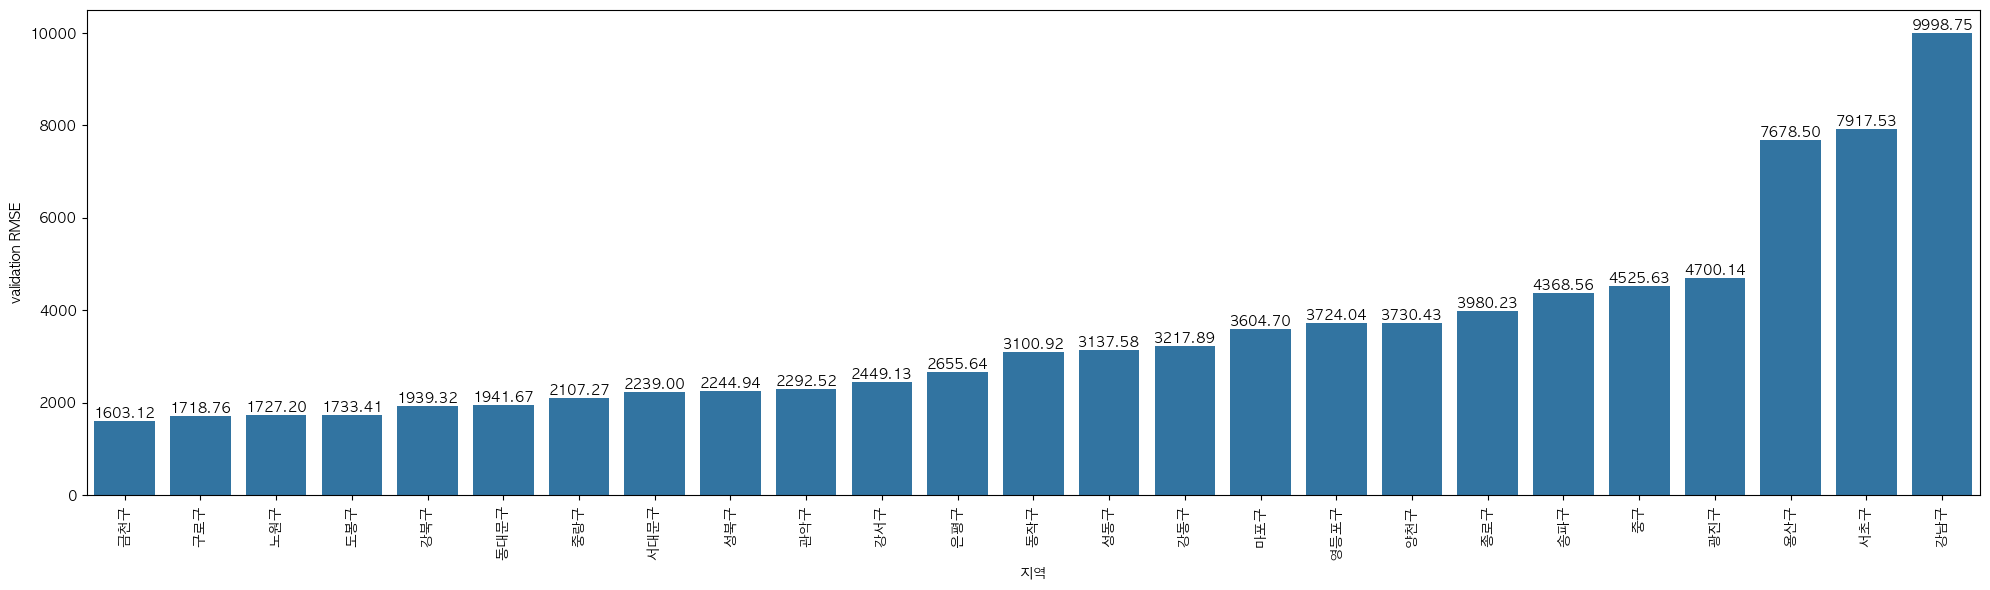

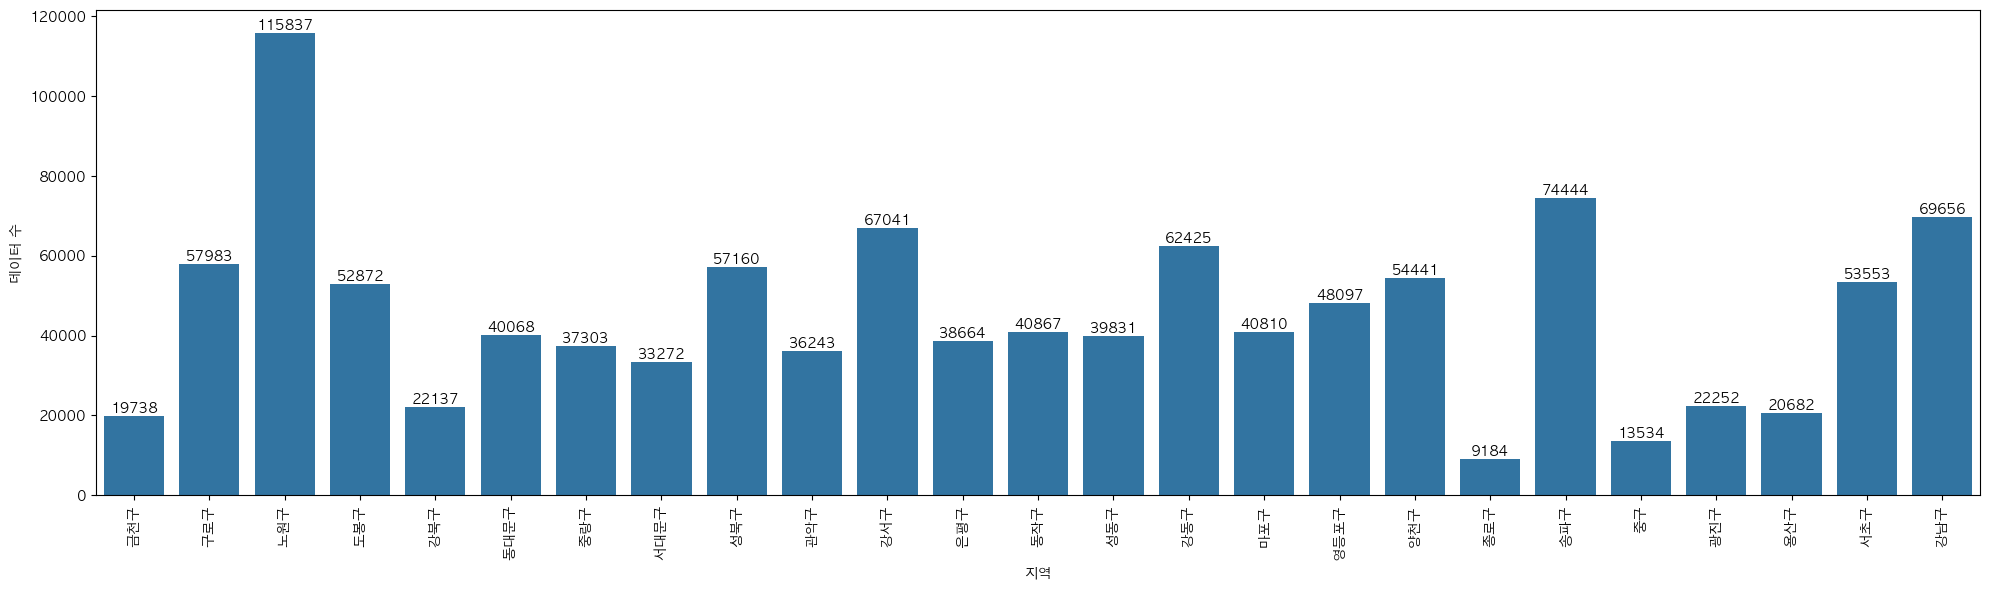

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [40]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_N_mean_features(3).csv', index=False)

,id,target
1118822,1118822,183633.987127
1118823,1118823,280970.710519
1118824,1118824,300185.633769
1118825,1118825,250162.875873
1118826,1118826,197602.067095
...,...,...
1128089,1128089,68433.806357
1128090,1128090,68345.906695
1128091,1128091,78606.671214
1128092,1128092,67422.852812


id        0
target    0
dtype: int64


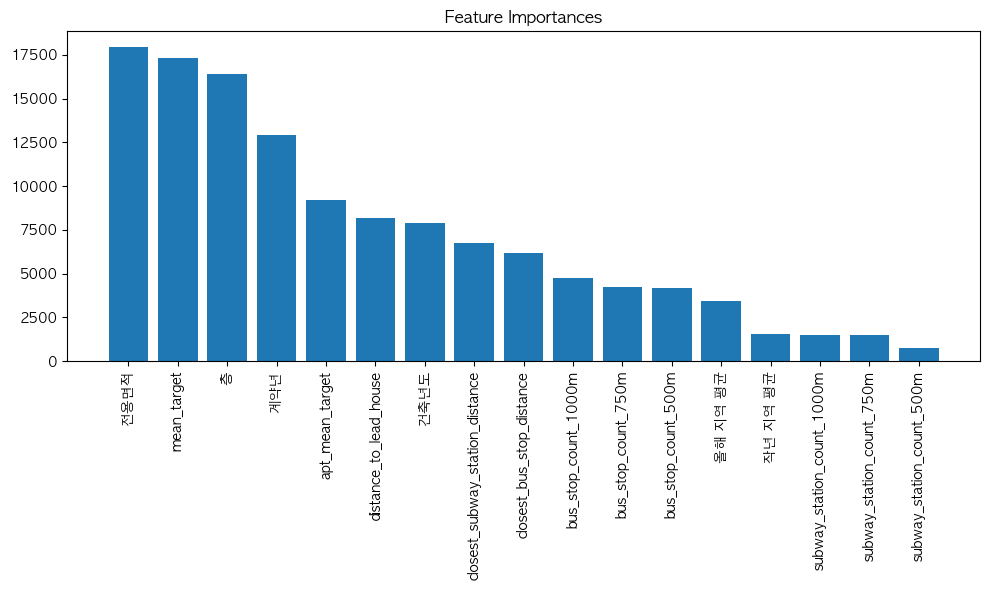

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()